## Load the Adult Data

In [3]:
!pip install torch folktables

Defaulting to user installation because normal site-packages is not writeable


In [17]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from folktables import ACSDataSource, ACSEmployment, ACSIncome

Load the Adult dataset as numpy array.

In [54]:
data_source = ACSDataSource(survey_year='2014', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(ca_data)

Load the numpy array as torch tensors.

In [ ]:
print(features.shape, label.shape , group)
label = label.astype(int)
print(label)
import torchvision
mean = np.mean(features)
std = np.std(features)

transforms=torchvision.transforms.Normalize(mean=mean, std=std)
print(mean, std)
# torchvision.transforms.Normalize(
#       [, meanOfChannel2, meanOfChannel3] 
#     , [stdOfChannel1, stdOfChannel2, stdOfChannel3] 
# )

In [ ]:
SEED = 0
BATCH_SIZE = 128 



# generate the training data index and validation data index
np.random.seed(SEED)
random_index = np.random.rand(len(features))  
random_index = np.argsort(random_index)
train_index = random_index[: int(len(features)*0.8)]  # 80% data for training
val_index = random_index[int(len(features)*0.8):]


# generate the training data and validation data
train_data = features[train_index]
train_label = label[train_index]
val_data = features[val_index]
val_label = label[val_index]
print('The training data has the size of {} and the val has the size of {}'.format(str(len(train_data)), str(len(val_data))))


# prepare the dataloader
train_dataset = TensorDataset(torch.Tensor(train_data), torch.Tensor(train_label))
val_dataset = TensorDataset(torch.Tensor(val_data), torch.Tensor(val_label))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0, drop_last=False)



In [ ]:
import torch.nn as nn

# prepare our network
class my_net(nn.Module):
    def __init__(self, input_dim=10, emb_dim=64, mlp_ratio=4, num_classes=2): 
        super().__init__()  
        
        self.embedding = nn.Linear(input_dim, emb_dim)
        self.block1 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.block2 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.cls = nn.Sequential(
             nn.LayerNorm(emb_dim),
             nn.Linear(emb_dim,  num_classes) 
        )
    
    def forward(self, x):
        
        x = self.embedding(x)
        x = self.block1(x)             
        x = self.cls(x)
        
        return x


def topk(output, target, ks=(1,)):
    """Returns one boolean vector for each k, whether the target is within the output's top-k."""
    batch_size = outputs.size(0)
    _, pred = output.topk(max(ks), 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [correct[:k].max(0)[0].float().mean() for k in ks]

def normalization(tensor, mean, std):
    return tensor - mean / std

In [ ]:
LR = 0.1
NUM_EPOCH = 10
LOG_STEP = 200


our_net = my_net()
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(our_net.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=NUM_EPOCH)

train_all_loss = []
val_all_loss = []
train_acc = []
val_acc = []

for epoch in range(NUM_EPOCH):
    our_net.train()
    avg_top1 = []
    for batch_id, (train_sample, train_labels) in enumerate(train_loader):   
        
        train_labels = train_labels.long()
        output = our_net(normalization(train_sample, mean=mean, std=std))
        loss = criterion(output, train_labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_all_loss.append(loss.item())
        top1 = topk(output, train_labels, ks=(1,))
        avg_top1.extend(top1)
        if batch_id % LOG_STEP ==0:
            print('Epoch {} Current Step {}/{}: loss is {losses:.6f}'
                  .format(str(epoch) ,str(batch_id), str(len(train_loader)), losses = loss.item()))
    train_acc.append(np.mean(avg_top1))
    our_net.eval()
    avg_top1 = []
    with torch.no_grad():
        for  batch_id, (val_sample, val_labels) in enumerate(val_loader):
            val_labels = val_labels.long()
            outputs = our_net(normalization(val_sample, mean=mean, std=std))
            loss = criterion(outputs, val_labels)
            val_all_loss.append(loss.item())
            top1 = topk(outputs, val_labels, ks=(1,))
            avg_top1.extend(top1)
        print('------------------------------------------------')
        print('Epoch {} Validation acc is {top1:.6f}'
                  .format(str(epoch), top1 = np.mean(avg_top1)))
    val_acc.append(np.mean(avg_top1))
        
        

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the loss and acc
def plot_loss_fig(train_loss, val_loss):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_loss)), train_loss, label = 'train loss')
    plt.plot(range(len(val_loss)), val_loss, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Loss")  
    plt.ylabel('Loss') 
    plt.xlabel('Number of Steps ')
plot_loss_fig(train_all_loss, val_all_loss)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the acc and acc
def plot_acc_fig(train_acc, val_acc):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_acc)), train_acc, label = 'train loss')
    plt.plot(range(len(val_acc)), val_acc, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Acc")  
    plt.ylabel('Acc') 
    plt.xlabel('Number of Epochs ')
plot_acc_fig(train_acc, val_acc)

In [81]:
SEED = 0
BATCH_SIZE = 128 



# generate the training data index and validation data index
np.random.seed(SEED)
random_index = np.random.rand(len(features))  
random_index = np.argsort(random_index)
train_index = random_index[: int(len(features)*0.8)]  # 80% data for training
val_index = random_index[int(len(features)*0.8):]


# generate the training data and validation data
train_data = features[train_index]
train_label = label[train_index]
val_data = features[val_index]
val_label = label[val_index]
print('The training data has the size of {} and the val has the size of {}'.format(str(len(train_data)), str(len(val_data))))


# prepare the dataloader
train_dataset = TensorDataset(torch.Tensor(train_data), torch.Tensor(train_label))
val_dataset = TensorDataset(torch.Tensor(val_data), torch.Tensor(val_label))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0, drop_last=False)



The training data has the size of 147152 and the val has the size of 36789


In [105]:
import torch.nn as nn

# prepare our network
class my_net(nn.Module):
    def __init__(self, input_dim=10, emb_dim=64, mlp_ratio=4, num_classes=2): 
        super().__init__()  
        
        self.embedding = nn.Linear(input_dim, emb_dim)
        self.block1 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.block2 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.cls = nn.Sequential(
             nn.LayerNorm(emb_dim),
             nn.Linear(emb_dim,  num_classes) 
        )
    
    def forward(self, x):
        
        x = self.embedding(x)
        x = self.block1(x)             
        x = self.cls(x)
        
        return x


def topk(output, target, ks=(1,)):
    """Returns one boolean vector for each k, whether the target is within the output's top-k."""
    batch_size = outputs.size(0)
    _, pred = output.topk(max(ks), 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [correct[:k].max(0)[0].float().mean() for k in ks]

def normalization(tensor, mean, std):
    return tensor - mean / std

In [106]:
LR = 0.1
NUM_EPOCH = 10
LOG_STEP = 200


our_net = my_net()
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(our_net.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=NUM_EPOCH)

train_all_loss = []
val_all_loss = []
train_acc = []
val_acc = []

for epoch in range(NUM_EPOCH):
    our_net.train()
    avg_top1 = []
    for batch_id, (train_sample, train_labels) in enumerate(train_loader):   
        
        train_labels = train_labels.long()
        output = our_net(normalization(train_sample, mean=mean, std=std))
        loss = criterion(output, train_labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_all_loss.append(loss.item())
        top1 = topk(output, train_labels, ks=(1,))
        avg_top1.extend(top1)
        if batch_id % LOG_STEP ==0:
            print('Epoch {} Current Step {}/{}: loss is {losses:.6f}'
                  .format(str(epoch) ,str(batch_id), str(len(train_loader)), losses = loss.item()))
    train_acc.append(np.mean(avg_top1))
    our_net.eval()
    avg_top1 = []
    with torch.no_grad():
        for  batch_id, (val_sample, val_labels) in enumerate(val_loader):
            val_labels = val_labels.long()
            outputs = our_net(normalization(val_sample, mean=mean, std=std))
            loss = criterion(outputs, val_labels)
            val_all_loss.append(loss.item())
            top1 = topk(outputs, val_labels, ks=(1,))
            avg_top1.extend(top1)
        print('------------------------------------------------')
        print('Epoch {} Validation acc is {top1:.6f}'
                  .format(str(epoch), top1 = np.mean(avg_top1)))
    val_acc.append(np.mean(avg_top1))
        
        

Epoch 0 Current Step 0/1150: loss is 1.178331
Epoch 0 Current Step 200/1150: loss is 0.692017
Epoch 0 Current Step 400/1150: loss is 0.637004
Epoch 0 Current Step 600/1150: loss is 0.608995
Epoch 0 Current Step 800/1150: loss is 0.597958
Epoch 0 Current Step 1000/1150: loss is 0.577957
------------------------------------------------
Epoch 0 Validation acc is 0.709921
Epoch 1 Current Step 0/1150: loss is 0.557096
Epoch 1 Current Step 200/1150: loss is 0.546906
Epoch 1 Current Step 400/1150: loss is 0.537218
Epoch 1 Current Step 600/1150: loss is 0.617534
Epoch 1 Current Step 800/1150: loss is 0.546947
Epoch 1 Current Step 1000/1150: loss is 0.588763
------------------------------------------------
Epoch 1 Validation acc is 0.740341
Epoch 2 Current Step 0/1150: loss is 0.599228
Epoch 2 Current Step 200/1150: loss is 0.562133
Epoch 2 Current Step 400/1150: loss is 0.510716
Epoch 2 Current Step 600/1150: loss is 0.537835
Epoch 2 Current Step 800/1150: loss is 0.521416
Epoch 2 Current Step

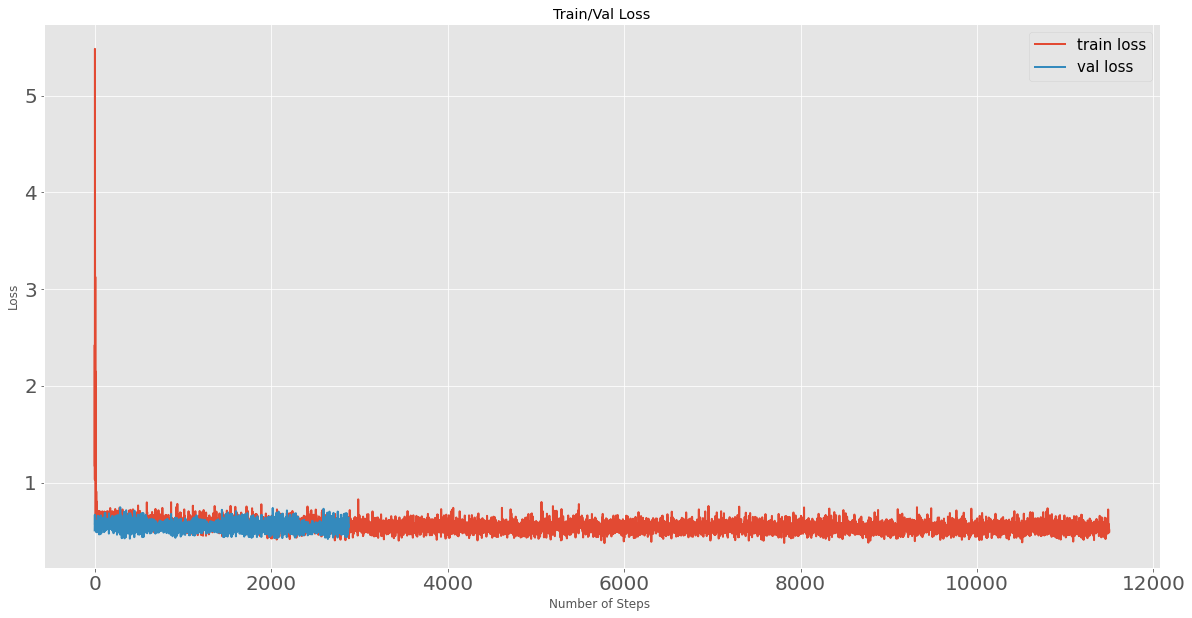

In [107]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the loss and acc
def plot_loss_fig(train_loss, val_loss):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_loss)), train_loss, label = 'train loss')
    plt.plot(range(len(val_loss)), val_loss, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Loss")  
    plt.ylabel('Loss') 
    plt.xlabel('Number of Steps ')
plot_loss_fig(train_all_loss, val_all_loss)

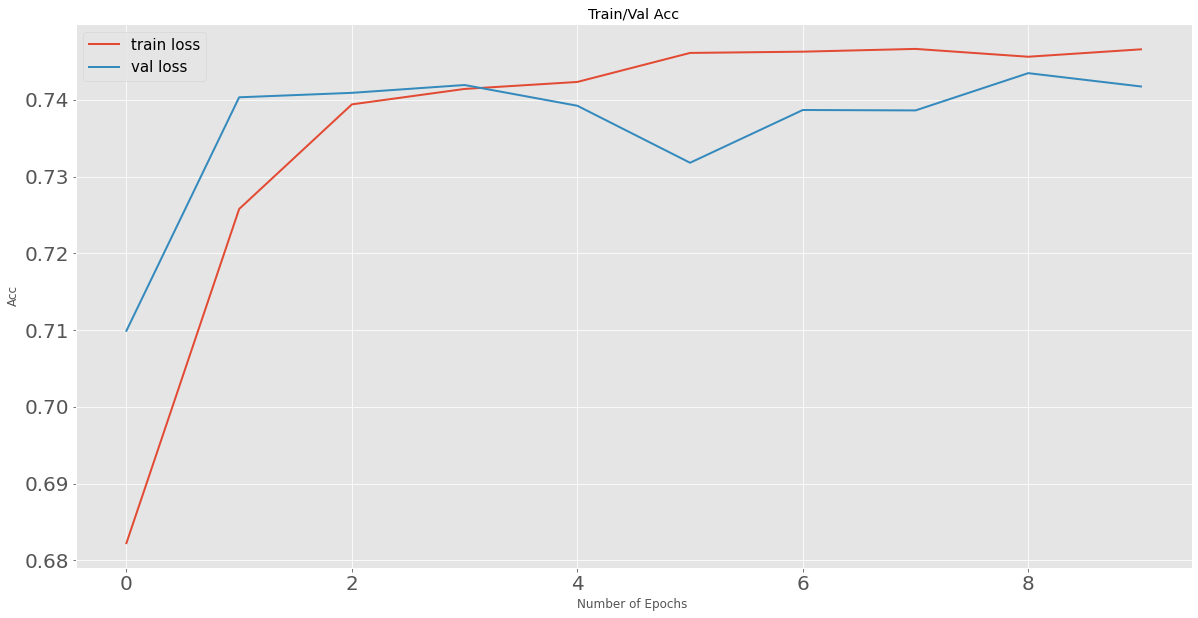

In [108]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the acc and acc
def plot_acc_fig(train_acc, val_acc):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_acc)), train_acc, label = 'train loss')
    plt.plot(range(len(val_acc)), val_acc, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Acc")  
    plt.ylabel('Acc') 
    plt.xlabel('Number of Epochs ')
plot_acc_fig(train_acc, val_acc)